In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import utils
import khammash_repro

In [2]:
# Load Training Data

path = "/home/smalani/controlledLearning/training_data"
training_L = np.load(path + "/training_L.npy")
training_sp = np.load(path + "/training_sp.npy")
training_t = np.load(path + "/training_t.npy")
training_y = np.load(path + "/training_y.npy")

In [3]:
# Define Dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, training_t, training_y, training_L, time_forecast=1):
        t0, t1, L0, L1, y0, y1 = self.split_data(training_t, training_L, training_y, time_forecast)
        self.t0 = t0
        self.t1 = t1
        self.L0 = L0
        self.L1 = L1
        self.y0 = y0
        self.y1 = y1

    def split_data(self, t, L, y, time_forecast):
        total_time_length = t.shape[1]

        t0, t1, L0, L1, y0, y1 = [], [], [], [], [], []

        for j in range(t.shape[0]):
            time_forecast = np.clip(time_forecast, 1, total_time_length-1)
            for i in range(total_time_length - time_forecast):
                t0.append(t[j, i])


                t1_add, L0_add, L1_add, y1_add, y0_add = [], [], [], [], []
                for k in range(time_forecast):
                    t1_add.append(t[j, i + k+1])
                    L0_add.append(L[j, i + k])
                    y0_add.append(y[j, i+k])
                    L1_add.append(L[j, i + k+1])
                    y1_add.append(y[j, i + k+1])

                t1.append(t1_add)
                L1.append(L1_add)
                L0.append(L0_add)
                y1.append(y1_add)
                y0.append(y0_add)


        t0 = np.array(t0)
        t1 = np.array(t1)
        L0 = np.array(L0)
        L1 = np.array(L1)
        y0 = np.array(y0)
        y1 = np.array(y1)

        return t0, t1, L0, L1, y0, y1

    def __len__(self):
        return self.t0.shape[0]

    def __getitem__(self, idx):
        t0 = torch.tensor(self.t0[idx]).unsqueeze(0)
        t1 = torch.tensor(self.t1[idx])#.unsqueeze(0)
        L0 = torch.tensor(self.L0[idx])#.unsqueeze(0)
        L1 = torch.tensor(self.L1[idx]).unsqueeze(0)
        y0 = torch.tensor(self.y0[idx])
        y1 = torch.tensor(self.y1[idx])

        return t0, t1, L0, L1, y0, y1

In [4]:
# Define the model
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device, max_step):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)

        self.input_scale = torch.tensor([1000, 100, 100, 1, 800]).unsqueeze(0).to(device)
        self.ode_scale = torch.tensor([100, 100, 100, 1]).unsqueeze(0).to(device)

        self.lambda_c = torch.nn.Parameter(torch.tensor([0.1], requires_grad=True).to(device))

        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        self.device = device
        self.max_step = max_step

    def scaledown_input(self, x):
        xmin = torch.tensor([800, 11, 50, 0, 0]).unsqueeze(0).to(self.device)
        xmax = torch.tensor([1837, 259, 510, 1, 800]).unsqueeze(0).to(self.device)
        x = (x - xmin) / (xmax - xmin)

        return x
    
    def scaleup_output(self, x):
        # xmin = torch.tensor([-220, -412, -218, -0.2]).unsqueeze(0).to(self.device)
        # xmax = torch.tensor([640, 461, 300, 0.042]).unsqueeze(0).to(self.device)
        # x = x * (xmax - xmin) + xmin
        scale_fac = torch.tensor([4000, 2000, 1500, 2]).unsqueeze(0).to(self.device)
        x = x * scale_fac
        return x

    def network(self, y0, L0):
        x = torch.cat((y0, L0), dim=1)
        x = self.scaledown_input(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        # x = torch.clamp(x, min=-1, max=2)

        x = self.scaleup_output(x)

        return x
    
    def ODEs(self, y0, L0):
        Tt, Td, C, phi = torch.movedim(y0,-1,0)
        Tt_gen, Td_gen, C_gen, lambda_p = torch.movedim(self.network(y0, L0),-1,0)# * self.ode_scale

        dTt = Tt_gen - Tt * lambda_p
        dTd = Td_gen - Td * lambda_p
        dC = C_gen - C * lambda_p
        dphi = (lambda_p - self.lambda_c) * phi * (1-phi)

        dydt = torch.stack((dTt, dTd, dC, dphi), dim=-1)

        return dydt
    
    def RK4(self, y0, L0, dt):
        k1 = self.ODEs(y0, L0)
        k2 = self.ODEs(y0 + dt/2 * k1, L0)
        k3 = self.ODEs(y0 + dt/2 * k2, L0)
        k4 = self.ODEs(y0 + dt * k3, L0)

        y1 = y0 + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

        return y1

    def move_to_device(self, t0, t1, L0, y0):
        t0 = t0.to(self.device)
        t1 = t1.to(self.device)
        L0 = L0.to(self.device)
        y0 = y0.to(self.device)

        return t0, t1, L0, y0
    
    def forward(self, t0, t1, L0, y0, autoreg=1):
        autoreg = np.clip(autoreg, 0, 1)
        t0, t1, L0, y0 = self.move_to_device(t0, t1, L0, y0)
        past_time = t0[:, [0]]
        y_out = []
        y_out.append(y0[:, 0])
        for i in range(t1.shape[1]):
            dt = t1[:, [i]] - past_time
            past_time = t1[:, [i]]
            dt_split = torch.rand(dt.shape).to(self.device)
            dt1 = dt * dt_split
            dt2 = dt - dt1

            L_in = L0[:, [i]]

            mask = (torch.rand(y0[:, i].shape).to(self.device) < autoreg)*1
            y_in = y0[:, i] * (1 - mask) + y_out[-1] * mask
            # if int(autoreg * t1.shape[1]) == 0 or i % int(autoreg * t1.shape[1]) == 0:
            #     y_in = y0[:, i]
            # else:
            #     y_in = y_out[-1]
            y_in = self.RK4(y_in, L_in, dt1)
            y_sol = self.RK4(y_in, L_in, dt2)

            y_out.append(y_sol)
        y_out = torch.stack(y_out[1:], dim=1)
        return y_out
    
    def forward_backup(self, t0, t1, L0, y0):
        t0, t1, L0, y0 = self.move_to_device(t0, t1, L0, y0)

        dt = t1 - t0
        dt_split = torch.rand(dt.shape).to(self.device)
        dt1 = dt * dt_split
        dt2 = dt - dt1

        y_int = self.RK4(y0, L0, dt1)
        y_pred = self.RK4(y_int, L0, dt2)

        return y_pred
    
    def forward_backup2(self, t0, t1, L0, y0):  
        t0, t1, L0, y0 = self.move_to_device(t0, t1, L0, y0)

        dt = t1 - t0
        t_tot = 0
        dt_arr = []
        while t_tot < torch.min(dt):
            t_append = torch.min(torch.ones_like(dt)*self.max_step, dt - t_tot)
            dt_arr.append(t_append)
            t_tot += self.max_step
        dt_arr = torch.cat(dt_arr, dim=1)
        dt_arr = dt_arr[:,np.random.permutation(dt_arr.shape[1])]
        dt_arr = torch.tensor(dt_arr).to(self.device)

        for i in range(dt_arr.shape[1]):
            y0 = self.RK4(y0, L0, dt_arr[:,[i]])

        return y0

In [5]:
training_L.shape

(100, 400)

In [6]:
# Create Dataset
time_forecast = 10000
# train_dataset = Dataset(training_t[:3,:], training_y[:3,:,:], training_L[:3,:], time_forecast=time_forecast)
# val_dataset = Dataset(training_t[[3],:], training_y[[3],:,:], training_L[[3],:], time_forecast=time_forecast)

dataset = Dataset(training_t, training_y, training_L, time_forecast=time_forecast)


# Min/Max Normalization


# Train Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define the dataloader
batch_size = 10000
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Create the model
input_size = 5
hidden_size = 64
output_size = 4

max_step = 0.04384

model = Model(input_size, hidden_size, output_size, device, max_step).to(device).to(torch.float64)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr= 1e-2)

# Define the lr scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-6)

In [7]:
# Define the training loop

def train_loop(dataloader, model, loss_fn, optimizer, lr_scheduler=None, autoreg=0):
    size = len(dataloader.dataset)
    train_loss = 0
    model.train()
    for batch, (t0, t1, L0, L1, y0, y1) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(t0, t1, L0, y0, autoreg)

        # Scale the predictions
        y1_scale = y1.to(device) / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)
        pred_scale = pred / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)

        loss_ar = loss_fn(pred_scale, y1_scale)

        pred = model(t0, t1, L0, y0, 0)

        # Scale the predictions
        y1_scale = y1.to(device) / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)
        pred = pred / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)

        loss_tf = loss_fn(pred_scale, y1_scale)
        # assert False

        loss = (torch.log10(loss_ar) + torch.log10(loss_tf))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()

        train_loss += loss.item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(t0)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    if lr_scheduler is not None:
        lr_scheduler.step(train_loss)
        

    lr = optimizer.param_groups[0]['lr']
    # lr = lr_scheduler._last_lr[0]
    # lr = lr_scheduler.get_last_lr()[0]

    return train_loss , lr


def val_loop(dataloader, model, loss_fn, autoreg=0):
    size = len(dataloader.dataset)
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for t0, t1, L0, L1, y0, y1 in dataloader:
            pred = model(t0, t1, L0, y0, autoreg)

            # Scale the predictions
            y1 = y1.to(device) / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)
            pred = pred / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)
            
            val_loss += torch.log10(loss_fn(pred, y1)).item()
    
    return val_loss 

In [8]:
trainnew = True

if trainnew:

    # Train the model
    tf_epochs = 100
    transition_epochs = 1000
    autoreg_epochs = 1000
    epochs = tf_epochs + transition_epochs + autoreg_epochs
    train_loss_list = []
    val_loss_list = []
    lr_list = []

    best_val_loss = np.inf

    starting_ar = 0.9
    final_ar = 0.999

    pbar = tqdm(range(epochs))
    lr_scheduler = None

    for t in pbar:
        if t < tf_epochs:
            autoreg = starting_ar
        elif t < tf_epochs + transition_epochs:
            autoreg = starting_ar + (final_ar - starting_ar) * (t - tf_epochs) / transition_epochs
        else:
            autoreg = final_ar
            if lr_scheduler is None:
                lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)
                # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-6)
                for g in optimizer.param_groups:
                    g['lr'] = 1e-2

        train_loss, lr = train_loop(train_dataloader, model, loss_fn, optimizer, lr_scheduler, autoreg)
        val_loss = val_loop(val_dataloader, model, loss_fn, 1)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        lr_list.append(lr)

        pbar.set_description(f"Epoch {t+1}")
        pbar.set_postfix(train_loss=train_loss, lr=lr, autoreg=autoreg, val_loss=val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            path = "/home/smalani/controlledLearning/trained_models/"
            torch.save(model, path + "modeltrain_nocontroller_longtraj_greybox_best.pt")

    torch.save(model, path + "modeltrain_nocontroller_longtraj_greybox.pt")
            
        # pbar.set_postfix(train_loss=train_loss, val_loss=val_loss, lr=lr)

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch 00073: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00254: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00396: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00498: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00608: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00837: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00888: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00982: reducing learning rate of group 0 to 3.9063e-05.


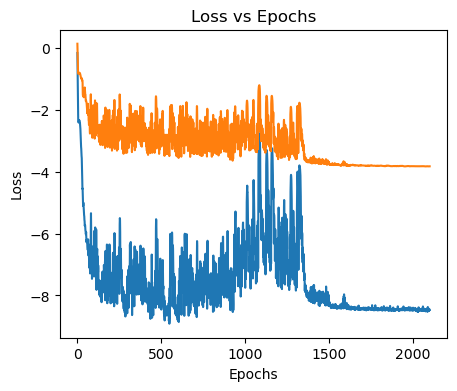

In [9]:
if trainnew: # Plot the loss

    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111)
    ax.plot(train_loss_list, label='Train Loss')
    ax.plot(val_loss_list, label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss vs Epochs')

In [10]:
# Load Model and test

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path = "/home/smalani/controlledLearning/trained_models/"
model = torch.load(path + "modeltrain_nocontroller_longtraj_greybox.pt", map_location="cpu")
model.device = "cpu"

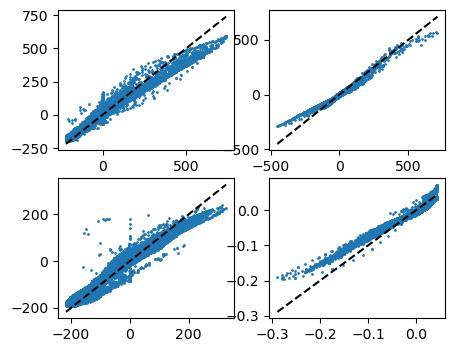

In [11]:
#  Performance on training data

def learned_model_ode(t, y0, L0):
    L0 = torch.tensor(L0).to(device)
    y0 = torch.tensor(y0).to(device)
    if len(y0.shape) == 1:
        y0 = y0.unsqueeze(0)
    while len(y0.shape) > len(L0.shape):
        L0 = L0.unsqueeze(-1)
    dydt = model.ODEs(y0, L0)

    return dydt.cpu().detach().numpy().squeeze()
    

y0_in = dataset.y0.reshape((-1, 4))
L0_in = dataset.L0.reshape((-1, 1))

true_dydt = khammash_repro.ode_fun(0, y0_in.T, L0_in.T).T * 60
learned_dydt = learned_model_ode(0, y0_in, L0_in)

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(221)
ax.scatter(true_dydt[:,0], learned_dydt[:,0], s=1)
ax.plot([np.min(true_dydt[:,0]), np.max(true_dydt[:,0])], [np.min(true_dydt[:,0]), np.max(true_dydt[:,0])], 'k--')

ax = fig.add_subplot(222)
ax.scatter(true_dydt[:,1], learned_dydt[:,1], s=1)
ax.plot([np.min(true_dydt[:,1]), np.max(true_dydt[:,1])], [np.min(true_dydt[:,1]), np.max(true_dydt[:,1])], 'k--')

ax = fig.add_subplot(223)
ax.scatter(true_dydt[:,2], learned_dydt[:,2], s=1)
ax.plot([np.min(true_dydt[:,2]), np.max(true_dydt[:,2])], [np.min(true_dydt[:,2]), np.max(true_dydt[:,2])], 'k--')

ax = fig.add_subplot(224)
ax.scatter(true_dydt[:,3], learned_dydt[:,3], s=1)
ax.plot([np.min(true_dydt[:,3]), np.max(true_dydt[:,3])], [np.min(true_dydt[:,3]), np.max(true_dydt[:,3])], 'k--')


In [12]:
# if trainnew:
#     path = "/home/smalani/controlledLearning/trained_models/"
#     torch.save(model, path + "modeltrain_nocontroller_longtraj.pt")

In [13]:
from scipy.integrate import solve_ivp

def learned_model_ode(t, y0, L0):
    L0 = torch.tensor(L0).to(device)
    y0 = torch.tensor(y0).to(device)
    if len(y0.shape) == 1:
        y0 = y0.unsqueeze(0)
    while len(y0.shape) > len(L0.shape):
        L0 = L0.unsqueeze(-1)
    dydt = model.ODEs(y0, L0)

    return dydt.cpu().detach().numpy().squeeze()

L0 = 117
x_init = khammash_repro.get_init_cond(L0=L0)
# x_init[-1] = 0.4
# x_init = dataset.y0[19,0,:]
L0 = dataset.L0[19,0]
t_span = np.array([0, 1000])
t_eval = np.linspace(t_span[0], t_span[1], 1000)

sol_true = solve_ivp(khammash_repro.ode_fun, t_span*60, x_init, args=(L0,), t_eval=t_eval*60, method='BDF', rtol=1e-10, atol=1e-10, first_step=1e-10)
sol_learned = solve_ivp(learned_model_ode, t_span, x_init, args=(L0,), t_eval=t_eval, method='BDF', rtol=1e-10, atol=1e-10, first_step=1e-10)

print(learned_model_ode(0, x_init, L0))
print(khammash_repro.ode_fun(0, x_init, L0))

[ 7.19166113e+01 -3.93730452e+01 -5.97199404e+01  1.33698579e-03]
[ 2.13162821e-14 -9.76700714e-01  0.00000000e+00 -1.20915031e-05]


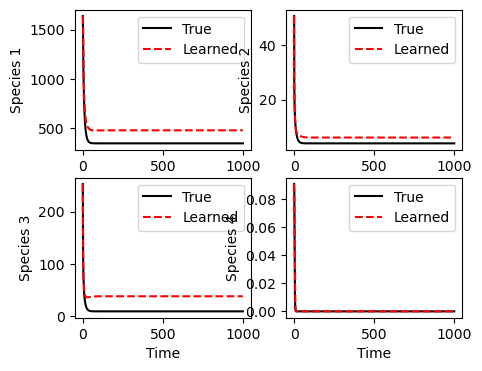

In [14]:
fig = plt.figure(figsize=(5, 4))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(sol_true.t/60, sol_true.y[i,:], 'k-', label='True')
    ax.plot(sol_learned.t, sol_learned.y[i,:], 'r--', label='Learned')
    ax.set_xlabel('Time')
    ax.set_ylabel('Species {}'.format(i+1))
    ax.legend()

In [15]:
from scipy.optimize import fsolve

def get_steady_state_fsolve(x, L):
    input = np.hstack((x, np.array([0.5])))
    ode_out = learned_model_ode(0, input, L)
    return ode_out[:-1]

def get_steady_state(L):
    x_guess = [1500, 100, 1000]
    ss, infodict, ier, mesg = fsolve(get_steady_state_fsolve, x_guess, args=(L,), xtol=1e-10, full_output=True, factor=0.01)
    return ss

def get_steady_state_fsolve_full(x, L):
    input = x
    ode_out = learned_model_ode(0, input, L)
    return ode_out

def get_steady_state_full(L):
    x_init = khammash_repro.get_init_cond(L0=L)
    t_span = np.array([0, 1000])
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    sol = solve_ivp(learned_model_ode, t_span, x_init, args=(L,), t_eval=t_eval, method='BDF', rtol=1e-3, atol=1e-6)

    x_guess = sol.y[:,-1]

    ss, infodict, ier, mesg = fsolve(get_steady_state_fsolve_full, x_guess, args=(L,), xtol=1e-10, full_output=True, factor=0.01)
    return ss

def L_equal_fsolve2(x):
    init_cond = get_steady_state(x)
    init_cond = np.hstack((init_cond, np.array([0.3])))
    ode_out = learned_model_ode(0, init_cond, x)
    return ode_out[-1]

[-0.9762462  -0.27422779  0.27069004  0.03506534]
[ 0.00000000e+00  1.77635684e-15 -1.77635684e-15  7.36497540e-04]


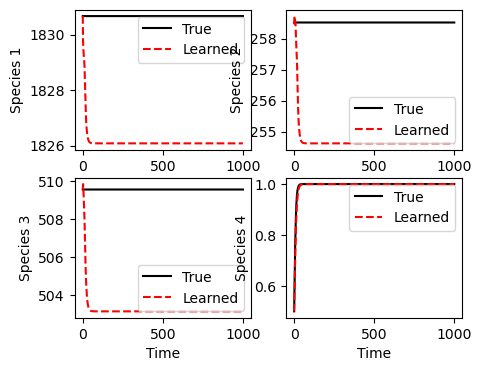

In [16]:
from scipy.integrate import solve_ivp

def learned_model_ode(t, y0, L0):
    L0 = torch.tensor(L0).to(device)
    y0 = torch.tensor(y0).to(device)
    if len(y0.shape) == 1:
        y0 = y0.unsqueeze(0)
    while len(y0.shape) > len(L0.shape):
        L0 = L0.unsqueeze(-1)
    dydt = model.ODEs(y0, L0)

    return dydt.cpu().detach().numpy().squeeze()

L0 = 800
L = 800
phi0 = 0.5

x_init = get_steady_state_full(L=L0)
x_init = khammash_repro.get_init_cond(L0=L0)
x_init[-1] = phi0
# x_init = dataset.y0[19,0,:]
# L0 = dataset.L0[19,0]
t_span = np.array([0, 1000])
t_eval = np.linspace(t_span[0], t_span[1], 100000)

sol_true = solve_ivp(khammash_repro.ode_fun, t_span*60, x_init, args=(L,), t_eval=t_eval*60, method='BDF', rtol=1e-10, atol=1e-10, first_step=1e-10)
sol_learned = solve_ivp(learned_model_ode, t_span, x_init, args=(L,), t_eval=t_eval, method='BDF', rtol=1e-10, atol=1e-10, first_step=1e-10)

print(learned_model_ode(0, x_init, L))
print(khammash_repro.ode_fun(0, x_init, L))

fig = plt.figure(figsize=(5, 4))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(sol_true.t/60, sol_true.y[i,:], 'k-', label='True')
    ax.plot(sol_learned.t, sol_learned.y[i,:], 'r--', label='Learned')
    ax.set_xlabel('Time')
    ax.set_ylabel('Species {}'.format(i+1))
    ax.legend()

# ax.set_xlim([0, 10])
# ax.set_ylim(phi0*0.95, phi0*1.05)

In [17]:
L_eq, infodict, ier, mesg = fsolve(L_equal_fsolve2, 300, xtol=1e-10, full_output=True, factor=1)
print(mesg)
print("Both strains grow equally well at L = " + str(L_eq[0]))

The solution converged.
Both strains grow equally well at L = 123.05297487873246


In [18]:
L = np.sort(np.concatenate([np.linspace(0,800,30), L_eq]))

phi_steady = []
for L0 in L:
    init_cond = get_steady_state_full(L=L0)
    phi_steady.append(init_cond[-1])

phi_steady = np.array(phi_steady)

In [19]:
L_eq_arr = np.ones(20) * L_eq
phi_eq_arr = np.linspace(0, 1, len(L_eq_arr))

L_plot_steady = np.sort(np.concatenate([L, L_eq_arr]))
phi_plot_steady = np.sort(np.concatenate([phi_steady, phi_eq_arr]))

In [20]:
L_vec_arr = np.linspace(0, 800, 20)
phi_vec_arr = np.linspace(np.min(phi_steady), np.max(phi_steady), 10)
phi_vec_arr = np.linspace(0, 1, 10)

dphi_vec = np.zeros((len(L_vec_arr), len(phi_vec_arr)))

for i, L0 in enumerate(L_vec_arr):
    for j, phi0 in enumerate(phi_vec_arr):
        init_cond = khammash_repro.get_init_cond(L0=L0)
        init_cond[-1] = phi0
        # init_cond = np.hstack((init_cond, np.array([phi0])))
        ode_out = learned_model_ode(0, init_cond, L0)
        dphi_vec[i,j] = ode_out[-1] / 60

        # print(i, j)

# print(dphi_vec)

In [21]:
def symlog(x):
    """ Returns the symmetric log10 value """
    return np.sign(x) * np.log10(np.abs(x)+1)

def transform(u, v):
    arrow_lengths = np.sqrt(u*u + v*v)
    # len_adjust_factor = np.log10(arrow_lengths + 1) / arrow_lengths
    len_adjust_factor = np.log10(np.abs(arrow_lengths+1)) / arrow_lengths
    return u*len_adjust_factor, v*len_adjust_factor


In [22]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

/tmp/ipykernel_3782635/836158580.py:48: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/tmp/ipykernel_3782635/2979105797.py:8: RuntimeWarning: invalid value encountered in divide
  len_adjust_factor = np.log10(np.abs(arrow_lengths+1)) / arrow_lengths


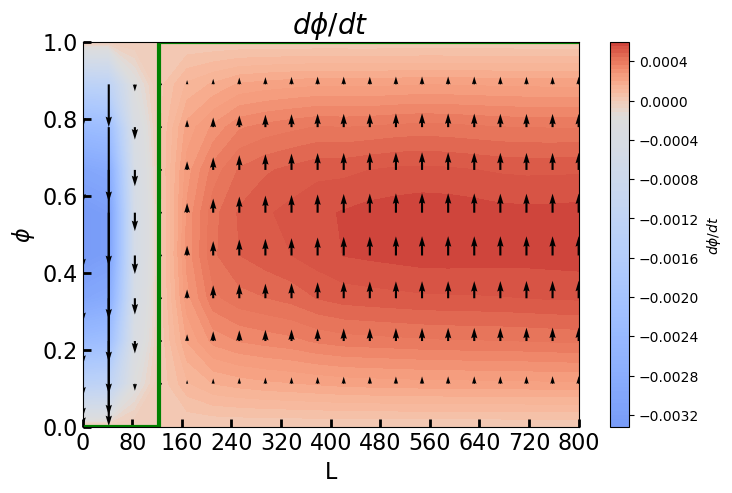

In [27]:
import matplotlib

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

newcmap = shiftedColorMap(matplotlib.cm.coolwarm, midpoint=1-np.max(dphi_vec)/(np.max(dphi_vec)-np.min(dphi_vec)))
angles=np.arctan2(dphi_vec.T,np.zeros_like(dphi_vec.T))*180.0/np.pi
U2, V2 = transform(np.zeros_like(dphi_vec.T), dphi_vec.T)

L_vec_mesh, phi_vec_mesh = np.meshgrid(L_vec_arr, phi_vec_arr)
cax = ax.contourf(L_vec_arr, phi_vec_arr, dphi_vec.T, 100, cmap= newcmap, vmin=-0.00524, vmax=0.000727)

ax.quiver(L_vec_mesh, phi_vec_mesh, U2, V2)
# ax.quiver(L_vec_mesh, phi_vec_mesh, np.zeros_like(dphi_vec.T), dphi_vec.T)

ax.plot(L_plot_steady, phi_plot_steady, linewidth=3, color='green')
ax.set_xlabel('L', fontsize=16)
ax.set_ylabel(r'$\phi$', fontsize=16)
ax.set_title(r'$d\phi/dt$', fontsize=20)
# ax.set_ylim([-0.05, 1.05])
# ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=6, direction='in')
ax.set_xticks([0, 80, 160, 240, 320, 400, 480, 560, 640, 720, 800])
# fig.colorbar(cax, ticks=[-0.005, -0.004, -0.003, -0.002, -0.001, 0.000, 0.001], label=r'$d\phi/dt$')
fig.colorbar(cax, label=r'$d\phi/dt$')
